# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


# Some parameters:
# Can check for the mean and deviation: https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
valid_size = 0.2
batch_size = 32

transform_training = transforms.Compose([transforms.RandomRotation(15),   
                                         transforms.RandomResizedCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ColorJitter(saturation=0.2, contrast=0.2, hue=0.2, brightness=0.2),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean, std)])
transform_testing = transforms.Compose([transforms.Resize((224,224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

train_data = datasets.ImageFolder("/data/landmark_images/train", transform=transform_training)
test_data = datasets.ImageFolder("/data/landmark_images/test", transform=transform_testing)

# Now we are going to create the validation data
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train)) # We obtain a list of values that we will make as an split
train_idx = indices[split:]
valid_idx = indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# And now we create the loders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

print(len(train_loader), len(valid_loader), len(test_loader))

125 32 40


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
Both the training and testing images are at a size of 224 pixels of width and height. As this size is enough for the analysis that I am conducting and the images can be adapted easily.

***Transformations***:
The transformations of data augmentation are only applied the training part, the transformations that I do are:
- The first thing that i am doing is rotating the image randomly 15 degrees
- I create an horizontal flip to create more randomness
- Also change the color parameters to add a little such as saturation, brightness, hue and contrast.

And then doing the transformations of toTensor and Normalizing the data. Note that mean and deviation are the ones that where used in the imagenet.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [2]:
## 3. Obtaining the classes: the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
train_data.classes

# For loop for obtainin the classes
def splitting() :
    splitted_class = []

    for i in train_data.classes:
        split_class = i.split(".")[1] # The second element is the one containing the name
        splitted_class += [split_class.replace("_"," ")]
    
    return splitted_class
        

splitted_classes = splitting()

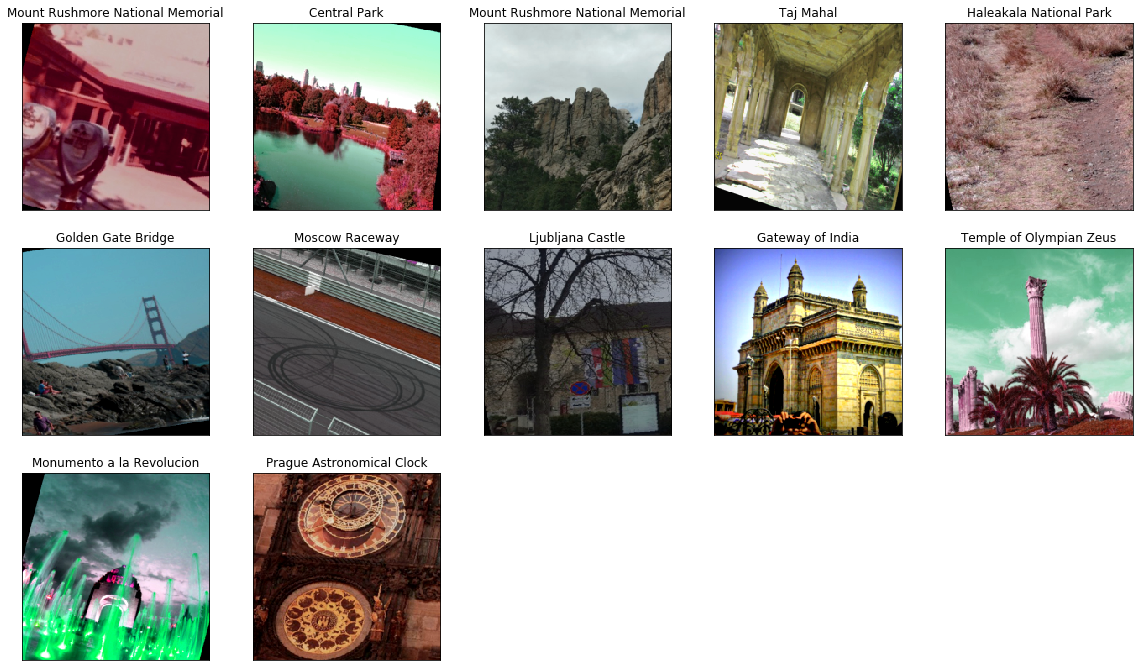

In [3]:
import matplotlib.pyplot as plt
from torch import Tensor
%matplotlib inline

## TODO: visualize a batch of the train data loader
# 1. Obtain the batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 

# 2. Function for converting the images to the original state
def converting(img, mean, std):
    return img * std[:, None, None] + mean[:, None, None]

## 3. In the before cell

# 4. Represent those images
fig = plt.figure(figsize=(20,20))
for idx in np.arange(12):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[], )
    img = converting(images[idx], Tensor(mean), Tensor(std)) 
    img = img.numpy() # Pass to numpy
    plt.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor image
    class_name = splitted_classes[labels[idx]] # And we obtain the classes that is for the label position we want
    ax.set_title(class_name)

### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
import torch
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
## TODO: select loss function
import torch.nn as nn
from torch import optim
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    # The modoel has proved to learn better with Adam
    return optim.Adam(model.parameters(), lr=0.0003)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

number_classes = len(train_data.classes)

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv_1 = nn.Conv2d(3, 16, 3, stride=1, padding=1) 
        self.conv_2 = nn.Conv2d(16, 32, 3, stride=1, padding=1) 
        self.conv_3 = nn.Conv2d(32, 64, 3, stride=1, padding=1) 
        self.conv_4 = nn.Conv2d(64, 128, 3, stride=1, padding=1) 
        self.conv_5 = nn.Conv2d(128, 256, 3, stride=1, padding=1) 

        
        # And also define a max pooling layer
        self.pool = nn.MaxPool2d(2,2)        
        
        # And linear models
        self.fc1 = nn.Linear(7*7*256, 1024) # 7 as (224/(2*2*2*2*2) and 128 as it is the depth
        # self.fc2 = nn.Linear(512, number_classes)

        # Other model that i tested
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, number_classes)

        
        # Will define a dropout of 0.3
        self.dropout = nn.Dropout(0.2)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))
        x = self.pool(F.relu(self.conv_3(x)))
        x = self.pool(F.relu(self.conv_4(x)))
        x = self.pool(F.relu(self.conv_5(x)))

        
        # Flatten the input
        x = x.view(-1, 7*7*256)
        
        # Add the dropout
        x = self.dropout(x)
        
        # Add the linear layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

model_scratch

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=50, bias=True)
  (dropout): Dropout(p=0.2)
)

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  First of all, i start defining which will be the convolutional layers of the network. In this case, after a lot of testing of architecture, I have chosen to have 5 convolutional layers, each of them doubling the depth and having a stride and padding = 1.
Then i define the max pooling layer which has the parameters of 2 and 2, and this will make to reduce the size by 2.
Furthermore, i am defining the fully connected linear layers, which are 4. The first one is going to take an input dimension of 7 * 7 * 256, and then return 1024. The following linear layers will reduce the dimensions by 2, and the final one will return the amount of classes that we want to predict. This way we ensure a good prediction power.
Finally, i am defining a dropout of 0.2 which will help to prevent overfitting.

Then in the forward pass, for each convolutional layer i apply a relu activation function and then i do the max pooling layers to obtain the most important features.
In the next step, i flatten the final output of the last convolutional layer to make sure i can feed it in to the linear layer. And then i pass the information through the linear layers and applying the dropout between those layers.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            # Obtain the output from the model
            output = model(data)
            # Obtain loss
            loss = criterion(output, target)
            # Backward induction
            loss.backward()
            # Perform optimization step
            optimizer.step()            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            # Obtain the loss
            loss = criterion(output, target)
            # Add this loss to the list (same as before but instead of train we use valid)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            # Print an alert
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model..'.format(
                valid_loss_min,
                valid_loss))

            torch.save(model.state_dict(), save_path)
            
            # Update the new minimum
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [9]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    
    # for every Linear layer in a model >
    if classname.find('Linear') != -1:
        # Get the number of the inputs
        n = m.in_features
        # Define which will be the y
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y) 
        # Bias will be filled with 0
        m.bias.data.fill_(0)


#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.887435 	Validation Loss: 3.834685
Validation loss decreased (inf --> 3.834685).  Saving model..
Epoch: 2 	Training Loss: 3.797705 	Validation Loss: 3.788235
Validation loss decreased (3.834685 --> 3.788235).  Saving model..
Epoch: 3 	Training Loss: 3.748479 	Validation Loss: 3.750326
Validation loss decreased (3.788235 --> 3.750326).  Saving model..
Epoch: 4 	Training Loss: 3.683395 	Validation Loss: 3.671883
Validation loss decreased (3.750326 --> 3.671883).  Saving model..
Epoch: 5 	Training Loss: 3.585587 	Validation Loss: 3.565821
Validation loss decreased (3.671883 --> 3.565821).  Saving model..
Epoch: 6 	Training Loss: 3.517021 	Validation Loss: 3.513509
Validation loss decreased (3.565821 --> 3.513509).  Saving model..
Epoch: 7 	Training Loss: 3.410525 	Validation Loss: 3.464198
Validation loss decreased (3.513509 --> 3.464198).  Saving model..
Epoch: 8 	Training Loss: 3.338053 	Validation Loss: 3.366315
Validation loss decreased (3.464198 --> 3.366315

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [12]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.885601 	Validation Loss: 3.850695
Validation loss decreased (inf --> 3.850695).  Saving model..
Epoch: 2 	Training Loss: 3.820332 	Validation Loss: 3.804566
Validation loss decreased (3.850695 --> 3.804566).  Saving model..
Epoch: 3 	Training Loss: 3.774317 	Validation Loss: 3.767479
Validation loss decreased (3.804566 --> 3.767479).  Saving model..
Epoch: 4 	Training Loss: 3.736091 	Validation Loss: 3.707882
Validation loss decreased (3.767479 --> 3.707882).  Saving model..
Epoch: 5 	Training Loss: 3.655215 	Validation Loss: 3.607987
Validation loss decreased (3.707882 --> 3.607987).  Saving model..
Epoch: 6 	Training Loss: 3.569600 	Validation Loss: 3.590461
Validation loss decreased (3.607987 --> 3.590461).  Saving model..
Epoch: 7 	Training Loss: 3.531715 	Validation Loss: 3.491814
Validation loss decreased (3.590461 --> 3.491814).  Saving model..
Epoch: 8 	Training Loss: 3.448179 	Validation Loss: 3.418394
Validation loss decreased (3.491814 --> 3.418394

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.231504


Test Accuracy: 41% (515/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [18]:
# Will only change batch size
batch_size_transfer = 12

# And now we create the loders
train_loader_transfer = DataLoader(train_data, batch_size=batch_size_transfer, sampler=train_sampler)
valid_loader_transfer = DataLoader(train_data, batch_size=batch_size_transfer, sampler=valid_sampler)
test_loader_transfer = DataLoader(test_data, batch_size=batch_size_transfer)

loaders_transfer = {'train': train_loader_transfer, 'valid': valid_loader_transfer, 'test': test_loader_transfer}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [15]:
## TODO: select loss function
from torch.nn import CrossEntropyLoss

criterion_transfer = CrossEntropyLoss()

# And then the function for the optimizer, where the model will be the one which we do the transfer learning
def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [26]:
## TODO: Specify model architecture
# Import the model
from torchvision import models

# We will use vgg16 as the base model
model_transfer = models.vgg16(pretrained=True)
for param in model_transfer.features.parameters():
    param.requires_grad = False # With this we make that it is no train

# We will change the the final layer of this model with a fully connected layer that meets our classifications
input_layer = model_transfer.classifier[6].in_features # We obtain the inputs
output_layer = nn.Linear(input_layer, number_classes)

model_transfer.classifier[6] = output_layer
    
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
What we have done first is to obtain the model of vgg16, with the weights already trained. This will help as the network trained processing images, so those weights learned how to recognize some important features that could help us in our classification task.
Then, as we want to train the final part of the network but not the already trained part, we will freeze the parameters of this model.
The next step is to replace the output layer of the vgg16, in order to put a linear layer that will give us the wanted class labels.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [24]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
def transfer_training(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf
    
    for epoch in range(0, n_epochs):
        train_loss = 0.
        valid_loss = 0.
        
        # Train the model
        for batch_idx, (data, target) in enumerate(loaders["train"]):
            if use_cuda:
                data, target = data.cuda(), target.cuda() # Pass them to GPU
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        
        # Validation
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            # Print an alert
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model..'.format(
                valid_loss_min,
                valid_loss))

            torch.save(model.state_dict(), save_path)
            
            # Update the new minimum
            valid_loss_min = valid_loss
        
    return model

In [27]:
model_transfer = transfer_training(15, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer, use_cuda, "model_transfer.pt")

Epoch: 0 	Training Loss: 2.428448 	Validation Loss: 2.280395
Validation loss decreased (inf --> 2.280395).  Saving model..
Epoch: 1 	Training Loss: 1.491936 	Validation Loss: 1.499232
Validation loss decreased (2.280395 --> 1.499232).  Saving model..
Epoch: 2 	Training Loss: 1.286039 	Validation Loss: 2.642759
Epoch: 3 	Training Loss: 1.156575 	Validation Loss: 1.436749
Validation loss decreased (1.499232 --> 1.436749).  Saving model..
Epoch: 4 	Training Loss: 1.035644 	Validation Loss: 2.061439
Epoch: 5 	Training Loss: 0.977410 	Validation Loss: 2.401363
Epoch: 6 	Training Loss: 0.880776 	Validation Loss: 1.273332
Validation loss decreased (1.436749 --> 1.273332).  Saving model..
Epoch: 7 	Training Loss: 0.845812 	Validation Loss: 1.534819
Epoch: 8 	Training Loss: 0.785360 	Validation Loss: 2.945534
Epoch: 9 	Training Loss: 0.745329 	Validation Loss: 1.746391
Epoch: 10 	Training Loss: 0.681706 	Validation Loss: 1.253996
Validation loss decreased (1.273332 --> 1.253996).  Saving model.

In [28]:
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [29]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.955975


Test Accuracy: 77% (966/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [63]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image = Image.open(img_path)
    image = image.convert("RGB")
    
    image_transform = transforms.Compose([transforms.Resize((224,224)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean,std)])
    image = image_transform(image).float()
    image = torch.unsqueeze(image, 0)
    
    # Moving to cuda in the case there is GPU
    if use_cuda:
        image = image.cuda()
    
    model_transfer.eval()
    output = model_transfer(image) # Pass the image as the input
    values, index = output.topk(k) # Obtain the top k values
    
    top_output = []
    index = index.tolist()[0] # As it returns an array inside of an array
    # For the range of the index list
    for i in range(0, len(index)): 
        # Will append the class which corresponds ot the value of index at position i
        top_output.append(splitted_classes[index[i]])
    
    return top_output 
    

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Brooklyn Bridge',
 'Forth Bridge',
 'Sydney Harbour Bridge',
 'Sydney Opera House']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

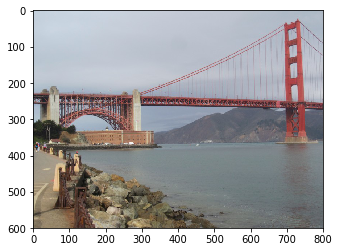

Predicted label number 0 is: Golden Gate Bridge
Predicted label number 1 is: Brooklyn Bridge
Predicted label number 2 is: Forth Bridge


In [88]:
def suggest_locations(img_path):
    # get landmark predictions
    k=3
    predicted_landmarks = predict_landmarks(img_path, k)
    
    ## TODO: display image and display landmark predictions
    image = Image.open(img_path)
    image = image.convert("RGB")
    
    plt.imshow(image)
    plt.show()  
    
    # And now print the suggestions
    for i in range(0, k):
        print(f"Predicted label number {i} is: {predicted_landmarks[i]}")

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is as the expected. There are different ways in which the model could be improved, as there can be more optimal hyperameters:
* Changing the learning rate
* Changing the optimizer
* Can run the model for more epochs

/home/workspace/nd101-c2-landmarks-starter/landmark_project/testing_images/


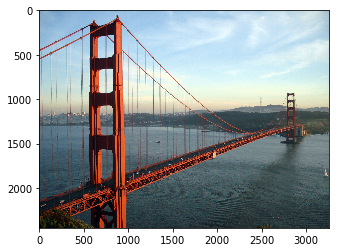

Predicted label number 0 is: Golden Gate Bridge
Predicted label number 1 is: Brooklyn Bridge
Predicted label number 2 is: Forth Bridge


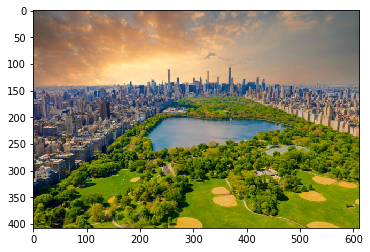

Predicted label number 0 is: Central Park
Predicted label number 1 is: Sydney Opera House
Predicted label number 2 is: Eiffel Tower


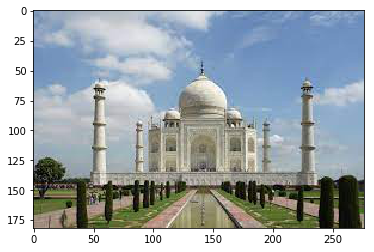

Predicted label number 0 is: Taj Mahal
Predicted label number 1 is: Stockholm City Hall
Predicted label number 2 is: Vienna City Hall


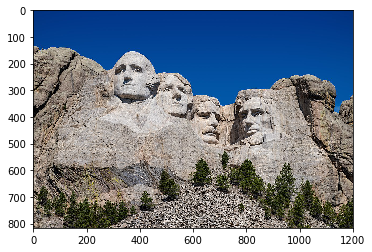

Predicted label number 0 is: Mount Rushmore National Memorial
Predicted label number 1 is: Externsteine
Predicted label number 2 is: Great Wall of China


In [89]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

import os

# Uploaded new images in a folder called testing_images
cwd = os.getcwd()
path = cwd + "/testing_images/"
print(path)

for image in os.listdir(path):
    url = path+image
    suggest_locations(url)